# Plot full tree with library strains highlighted

In [1]:
from IPython.display import HTML
import re
import copy
import pandas as pd
import baltic as bt
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

import numpy as np
import itertools
import requests


from io import StringIO as sio
from io import BytesIO as csio

import json
import Bio.Phylo
import Bio.SeqIO
from Bio import Phylo
import ete3

typeface='sans'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [2]:
# Input and output directories
datadir = 'data/'
resultsdir = 'results/'

os.makedirs(datadir, exist_ok=True)
os.makedirs(resultsdir, exist_ok=True)

# Basic color palette
color_palette = [
    '#345995', #blue
    '#03cea4', #teal
    '#ca1551', #red
    '#eac435', #yellow
               ]

## Plot from Nextstrain `seasonal-flu` TimeTree builds

In [3]:
# Add subclade labels to leaf nodes
strain_metadata = pd.read_csv('./data/nextclade.csv', sep = ';')

# Get library names
library_names = strain_metadata.seqName.unique()

# Get subclade to library name dict
libraryStrain_to_Subclade_dict = strain_metadata.set_index('seqName')['subclade'].to_dict()

In [4]:
# Identify treefile
json_treefile = './data/h3n2_ha.json'

In [5]:
# JSON translation
json_translation = {
    'absoluteTime': lambda k: k.traits['node_attrs']['num_date']['value'], 
    'name': 'name'
} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

ll, meta = bt.loadJSON(json_treefile,json_translation=json_translation) ## give loadJSON the name of the tree file, the translation dictionary and (optionally) the meta file



Tree height: 12.298000
Tree length: 387.978000
annotations present

Numbers of objects in tree: 3203 (1470 nodes and 1733 leaves)



In [6]:
# Define virus order
viral_plot_order = pd.read_csv('../../data/H3N2library_2023-2024_strain_order.csv')
library_strains_ls = [v for v in viral_plot_order.strain]

# Define vaccine strains
vaccine_strains = pd.read_csv('./data/vaccine_strains.csv')
vaccine_strains_ls = [v for v in vaccine_strains.strain]

# Define separate list where Massachusetts/18/2022 is reclassified as a 2023-circulating strains
vaccine_strains_no_Massachusetts = [item for item in vaccine_strains_ls if item != 'A/Massachusetts/18/2022']

# Define egg-passaged vaccine strains
# Define vaccine strains
egg_vaccine_strains = pd.read_csv('./data/egg-passaged_vaccine_strains.csv')
egg_vaccine_strains_ls = [v for v in egg_vaccine_strains.strain]

## Draw entire build with highlighted library strains 

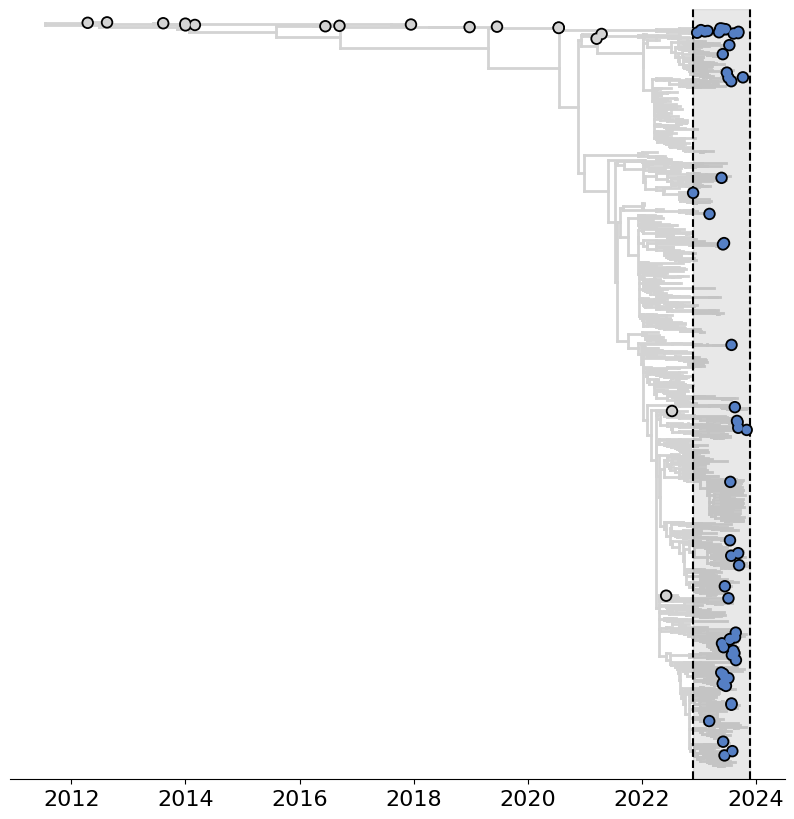

In [7]:
fig = plt.figure(figsize=(10,10),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

# colors and sizes for vaccine strains and library strains
point_colour = lambda k: 'lightgrey' if k.name in vaccine_strains_ls else '#557fc4'
point_size = lambda k: 40 if k.name in library_strains_ls else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

ll.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot collapsed tree
ll.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=16)

ax.set_ylim(-30,ll.ySpan+30)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])


# Add vertical line at library design
library_design_date = 2023.8877
plt.axvline(x=library_design_date, color='black', linestyle='--')

# Add vertical line 12 months prior to library design
prior_date = 2022.8877
plt.axvline(x=prior_date, color='black', linestyle='--')

# Add shaded box over library design period
# Add a shaded box between x1 and x2
plt.axvspan(prior_date, library_design_date, color='gray', alpha=0.18)


plt.draw()

# Save plot
outfile = os.path.join('./results/full_tree_library_highlighted.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

## Get subtree starting from most recent common ancestor of circulating strains

In [8]:
historical_vaccine_strains = [
    'A/Texas/50/2012', 'A/Texas/50/2012X-223A',
    'A/Switzerland/9715293/2013', 'A/Switzerland/9715293/2013NIB-88',
    'A/HongKong/4801/2014', 'A/HongKong/4801/2014egg',
    'A/Singapore/INFIMH-16-0019/2016', 'A/Singapore/INFIMH-16-0019/2016X-307A',
    'A/Kansas/14/2017', 'A/Kansas/14/2017X-327',
    'A/HongKong/45/2019', 'A/HongKong/2671/2019',
    'A/Cambodia/e0826360/2020', 'A/Cambodia/e0826360/2020egg',
    'A/Darwin/6/2021', 'A/Darwin/9/2021',
]

keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name not in historical_vaccine_strains] ## list of leaf objects that will remain in the tree - here only circulating strains in library
recent_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
recent_tree.treeStats()


Tree height: 12.298000
Tree length: 373.612000
multitype tree
annotations present

Numbers of objects in tree: 3180 (1463 nodes and 1717 leaves)



In [9]:
## MRCA of recent tree
ancestor = recent_tree.commonAncestor(keep_tips)
ancestor

## Get subtree
recent_subtree = recent_tree.subtree(k=ancestor, 
                                     stem=False
                              # traverse_condition=lambda node: node.traits['some_state'] == some_node.traits['some_state']
                             ) 
## Will only traverse through children in the same trait state as the starting node
recent_subtree.treeStats()


Tree height: 3.303000
Tree length: 366.197000
annotations present

Numbers of objects in tree: 3175 (1456 nodes and 1719 leaves)



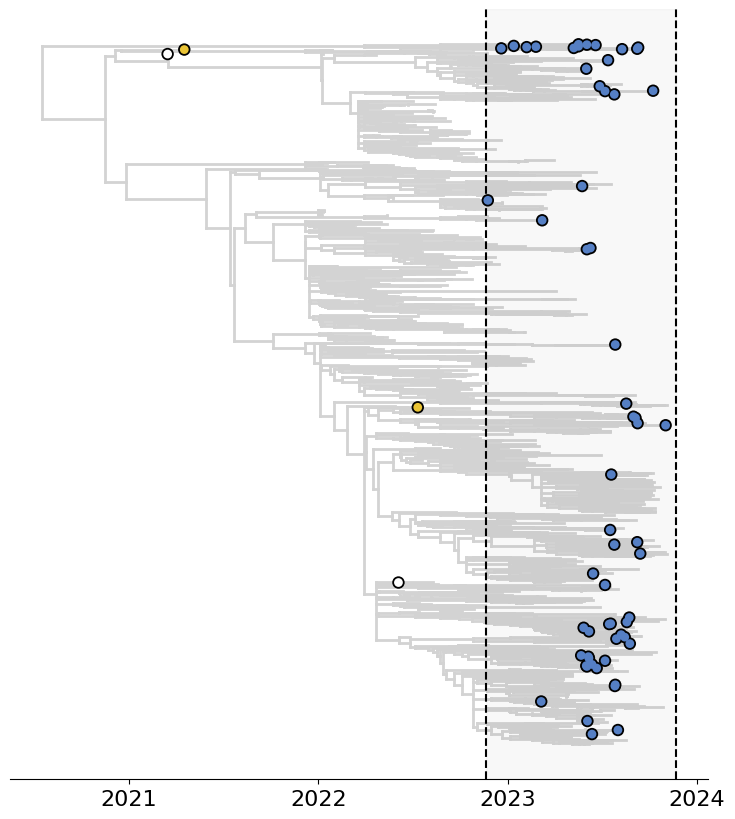

In [10]:
fig = plt.figure(figsize=(9,10),facecolor='w') ## create figure
ax=plt.subplot(
    facecolor='w') ## create axes

subtree_vaccine_strains = [
    'A/Darwin/6/2021', 
    'A/Darwin/9/2021',
    'A/Massachusetts/18/2022', 
    'A/Thailand/8/2022'
]

egg_subtree_vaccine_strains = [
    'A/Darwin/9/2021',
    'A/Thailand/8/2022'
]

# colors and sizes for vaccine strains and library strains
point_colour = lambda k: '#557fc4' if k.name not in subtree_vaccine_strains else '#eac435' if k.name in egg_subtree_vaccine_strains else 'white'
point_size = lambda k: 40 if k.name in vaccine_strains_ls else 40 if k.name in library_strains_ls else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

recent_subtree.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot tree
recent_subtree.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=16)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])

# Custom x-axis
ax.set_xticks([2020,2021,2022,2023,2024])


# Add vertical line at library design
library_design_date = 2023.8877
plt.axvline(x=library_design_date, color='black', linestyle='--')

# Add vertical line 12 months prior to library design
prior_date = 2022.8877
plt.axvline(x=prior_date, color='black', linestyle='--')

# Add shaded box over library design period
# Add a shaded box between x1 and x2
plt.axvspan(prior_date, library_design_date, color='gray', alpha=0.05)

# # Add node text
# # target_func=lambda k: k.isleaf()
# target_func=lambda k: k.name if k.name in vaccine_strains_ls else None ## which branches will be annotated
# text_func=lambda k: k.name ## what text is plotted
# text_x_attr=lambda k: k.absoluteTime ## where x coordinate for text is
# text_y_attr=lambda k: k.y + 0.3 ## where x coordinate for text is
# kwargs={'va':'bottom','ha':'center','size': 9, 
#         'style': 'italic'
#        } ## kwargs for text
# recent_subtree.addText(ax, x_attr=text_x_attr, y_attr=text_y_attr,
#                        target=target_func, text=text_func, 
#                        **kwargs) ## text will use a different x attribute function to shift it to the right



plt.draw()

# Save plot
outfile = os.path.join('./results/recent_tree_library_highlighted.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()



## Reduce tree to just vaccine strains

In [11]:
keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in vaccine_strains_ls] ## list of leaf objects that will remain in the tree - here only circulating strains in library
vaccine_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
vaccine_tree.treeStats()


Tree height: 10.981000
Tree length: 25.490000
multitype tree
annotations present

Numbers of objects in tree: 49 (32 nodes and 17 leaves)



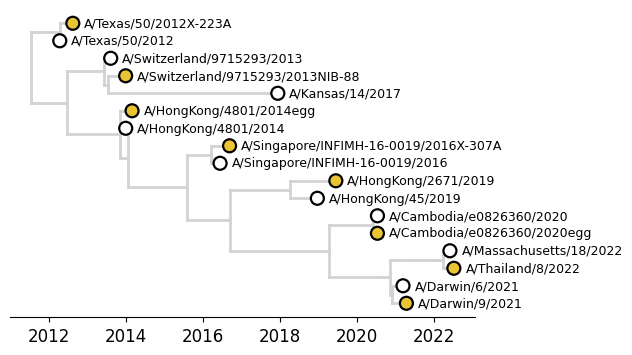

In [12]:
fig = plt.figure(figsize=(6,4),facecolor='w') ## create figure
ax=plt.subplot(
    facecolor='w') ## create axes


# colors and sizes for vaccine strains and library strains
point_colour = lambda k: '#eac435' if k.name in egg_vaccine_strains_ls else 'white' if k.name in vaccine_strains_ls else 'black' ## colour red if vaccine strain, blue if circulating, otherwise black
# point_shape = 
point_size = lambda k: 60 if k.name in egg_vaccine_strains_ls else 60 if k.name in vaccine_strains_ls else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

vaccine_tree.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot tree
vaccine_tree.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=12)
# Custom x-axis
# ax.set_xticks([2012,2014,2016,2018,2020,2022,2024,2025])
# ax.set_xticklabels([2012,2014,2016,2018,2020,2022,2024,''])
# ax.tick_params(axis='x',size=0)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])


# Add node text
target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: (k.name) ## what text is plotted
text_x_attr=lambda k: k.absoluteTime + 0.3 ## where x coordinate for text is
kwargs={'va':'center','ha':'left','size': 9} ## kwargs for text

vaccine_tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function to shift it to the right



plt.draw()

# Save plot
outfile = os.path.join('./results/vaccine_tree.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

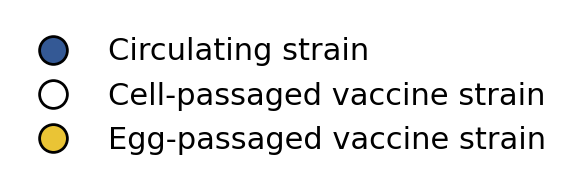

In [13]:
# Make key for egg-passaged versus cell-passaged versus 2023-circulating strains
plt.close()

fig = plt.figure(figsize=(4,2),facecolor='w') ## create figure

tree_key = {

    'Circulating strain':  '#345995', # palette blue
    'Cell-passaged vaccine strain': 'white',
    'Egg-passaged vaccine strain': '#eac435', # palette yellow

                   }


# draw a legend for the country to color mapping
# for circles: https://stackoverflow.com/a/44113141
patches = [plt.plot([], [], marker='o', markeredgecolor = 'black', markeredgewidth=2, ms=20, ls='', color=color, label=strain)[0]
           for strain, color in tree_key.items()]
plt.gca().set_axis_off()
legend = plt.legend(handles=patches,
                    loc='best',
                    frameon=False,
                    prop={'family': 'Sans'}
                   )

# draw just legend https://stackoverflow.com/a/47749903
tree_legend = './results/tree_legend.png'
fig = legend.figure
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(tree_legend, bbox_inches='tight', dpi=600)

## Reduce tree to just those in the library


Tree height: 12.290000
Tree length: 74.951000
multitype tree
annotations present

Numbers of objects in tree: 423 (345 nodes and 78 leaves)



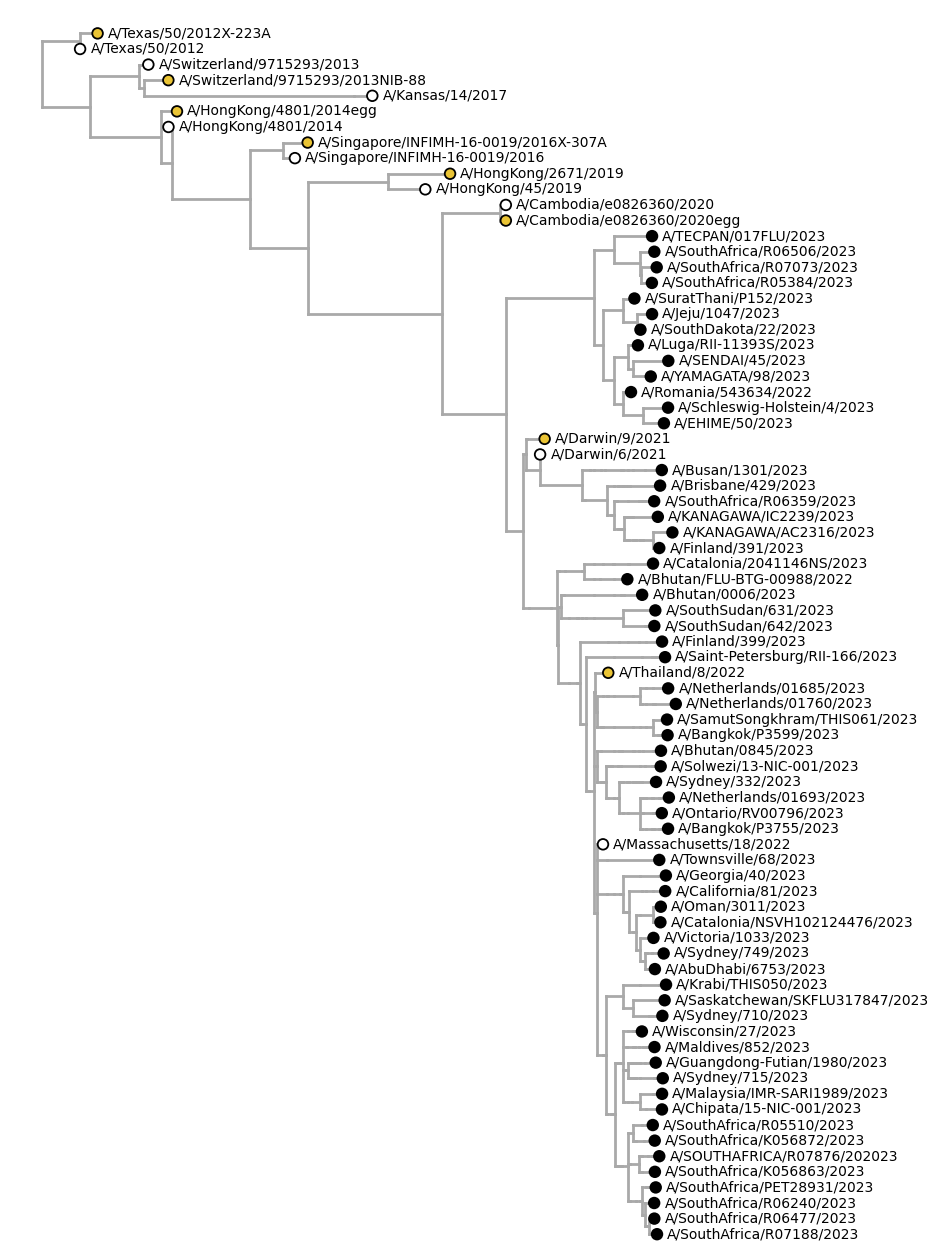

In [14]:
# Get reduced tree
keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strains_ls] ## list of leaf objects that will remain in the tree - here only circulating strains in library
library_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
library_tree.treeStats() # Print tree stats

# Draw tree
fig = plt.figure(figsize=(9,16),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

point_size = lambda k: 40 if k.name in library_strains_ls else 0
point_colour = lambda k: '#eac435' if k.name in egg_vaccine_strains_ls else 'white' if k.name in vaccine_strains_ls else 'black' ## colour red if vaccine strain, blue if circulating, otherwise black

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

# Plot tree and points
library_tree.plotTree(ax,
            colour='darkgrey',
            linewidths = 0.2,
            zorder=10) ## plot collapsed tree
library_tree.plotPoints(ax,target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=14) ## plot points on tips

# Start finagling the node labels
target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name ## what text is plotted
text_x_attr=lambda k: k.x + 0.2 ## where x coordinate for text is

kwargs={'va':'center','ha':'left','size': 10,
       } ## kwargs for text

library_tree.addText(ax,
                     x_attr=text_x_attr,
                     target=target_func,
                     text=text_func,
                     **kwargs) ## text will use a different x attribute function to shift it to the right

#### This was an attempt to draw dotted lines to text programatically that just was too annoying to get right
# Uncomment and text align right to view
# Draw lines from leaves to text
# for k in library_tree.getExternal(): ## iterate over tips
#     # get width of each text object so we have coordinates of end of line
#     f = plt.figure()
#     r = f.canvas.get_renderer()
#     t = plt.text(0.8, 0.8, k.name, **kwargs)
#     bb = t.get_window_extent(renderer=r)
#     width = bb.width/90
#     plt.close()
#     # draw line
#     ax.plot([k.height, 19], [k.y,k.y], ls=':',lw=1,color='dimgrey') ## grey lines from every tip's date to the most recent date

# X-axis tick params
ax.set_xticks([])
# Y-axis span
ax.set_ylim(0,library_tree.ySpan+1)
# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_yticks([])
ax.set_yticklabels([])


plt.draw()

# Save plot
outfile = os.path.join('./results/full_library_textLeft.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

## Reduce tree to just the 2023-circulating strains


Tree height: 12.290000
Tree length: 60.692000
multitype tree
annotations present

Numbers of objects in tree: 399 (337 nodes and 62 leaves)



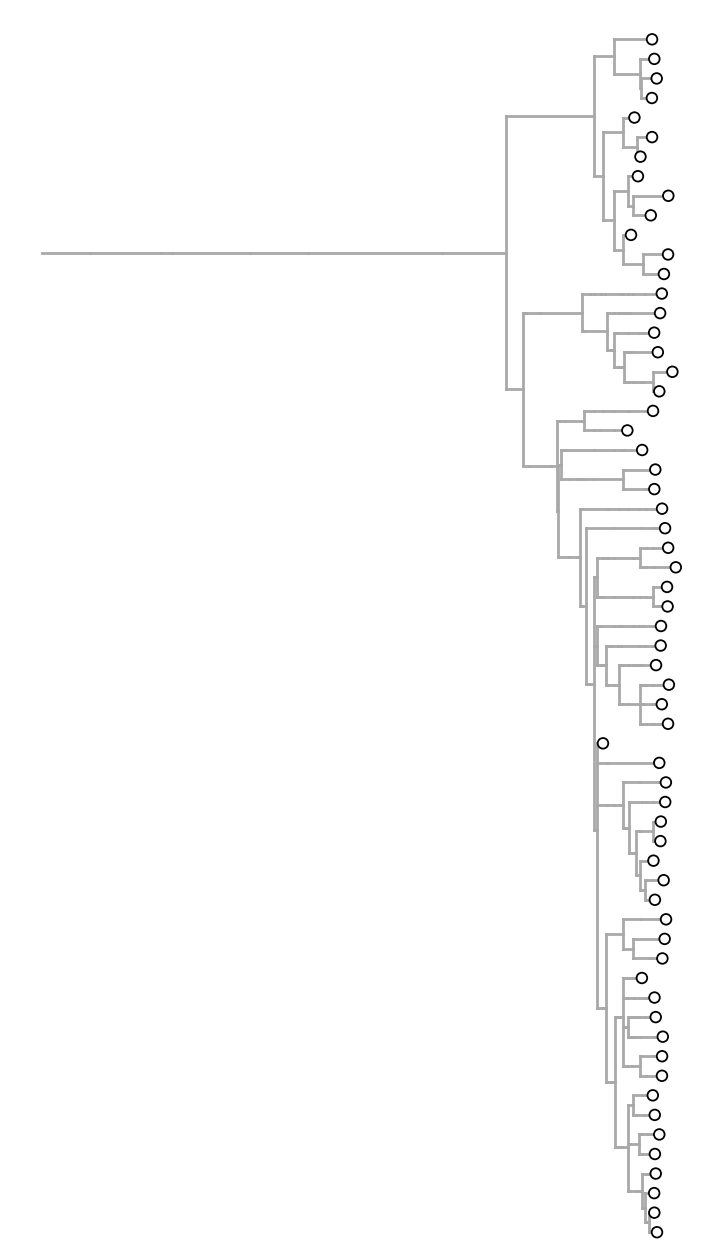

In [15]:
# Get reduced tree
keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strains_ls and k.name not in vaccine_strains_no_Massachusetts] # Get rid of vax strains expect Mass, which was also circulating 2023
circulating_library_tree=ll.reduceTree(keep_tips) # Retrieve a reduced tree (multitype by default)
circulating_library_tree.treeStats() # Print tree stats

# Draw tree
fig = plt.figure(figsize=(9,16),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

point_size = lambda k: 40 if k.name in library_strains_ls else 0
point_colour = lambda k: 'white' if k.name in library_strains_ls else 'white' if k.name in vaccine_strains else 'black' ## colour red if vaccine strain, blue if circulating, otherwise black

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

# Plot tree and points
circulating_library_tree.plotTree(ax,
            colour='darkgrey',
            linewidths = 0.2,
            zorder=10) ## plot collapsed tree
circulating_library_tree.plotPoints(ax,target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=14) ## plot points on tips


# X-axis tick params
ax.set_xticks([])
# Y-axis span
ax.set_ylim(0,circulating_library_tree.ySpan+1)
# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_yticks([])
ax.set_yticklabels([])


plt.draw()

# Save plot
outfile = os.path.join('./results/circulating2023_library_noText.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

In [16]:
# Trying to label nodes with mutations
red_nodes = []
gold_nodes = []


# Get names and attrs of branches
for k in circulating_library_tree.Objects: ## iterate over tips
    node, subclade, haplotype = ([k.name, k.traits['node_attrs']['subclade']['value'], 
                                 k.traits['node_attrs']['haplotype']['value']])
    mutations = k.traits['branch_attrs']['labels']['aa'] if 'HA1' in k.traits['branch_attrs']['mutations'] else 'nan'


    # 276
    if 'J.2' in subclade:
        # print(node, subclade, haplotype, mutations)
        red_nodes.append(node)
    if 'Saint' in node:
        # print(node, subclade, haplotype, mutations)
        red_nodes.append(node)
    if 'SouthSudan' in node:
        # print(node, subclade, haplotype, mutations)
        red_nodes.append(node)
    if '276' in mutations:
        # print(node, subclade, haplotype, mutations)
        red_nodes.append(node)        
    if '275' in mutations:
        # print(node, subclade, haplotype, mutations)
        red_nodes.append(node)
        
    # 145
    if '145N' in mutations:
        # print(node, subclade, haplotype, mutations)
        gold_nodes.append(node)
    

# Load the JSON tree structure
with open(json_treefile, 'r') as f:
    tree_data = json.load(f)

# Build tree with branch attributes
def build_phylo_tree(node):
    clade_name = node.get('name', '')
    clade = Phylo.BaseTree.Clade(name=clade_name)
    clade.branch_attrs = node.get("branch_attrs", {})
    
    # If the node has children, create them recursively
    if 'children' in node:
        clade.clades = [build_phylo_tree(child) for child in node['children']]
    return clade

# Build the phylo tree from the JSON data
tree = build_phylo_tree(tree_data["tree"])

# Function to get all descendant nodes, edges, and leaves
def get_descendants_with_edges(clade, parent_name=None):
    descendants = []
    if clade.clades:
        for child in clade.clades:
            # Add the edge (parent -> child) info
            if parent_name:
                edge = (parent_name, clade.name, child.name)
                descendants.append(('edge', edge))
            descendants.append(('node', clade.name))  # Record current node
            descendants.extend(get_descendants_with_edges(child, parent_name=clade.name))
    else:
        descendants.append(('leaf', clade.name))  # Record leaf
    return descendants

# Traverse the tree to identify nodes and get all descendant nodes, branches, and leaves
gold_descendants = []
red_descendants = []

for n in tree.find_clades():
    
    if n.name in gold_nodes:
        gold_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                gold_descendants.append(desc[1])
            elif desc[0] == 'edge':
                gold_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                gold_descendants.append(desc[1])

    elif n.name in red_nodes:
        red_descendants.append(n.name)
        # Get names of descendants (nodes, edges, and leaves)
        descendants = get_descendants_with_edges(n)
        for desc in descendants:
            if desc[0] == 'node':
                red_descendants.append(desc[1])
            elif desc[0] == 'edge':
                red_descendants.append(desc[1])
            elif desc[0] == 'leaf':
                red_descendants.append(desc[1])


gold_descendants = (list(set(gold_descendants)))
red_descendants = (list(set(red_descendants)))

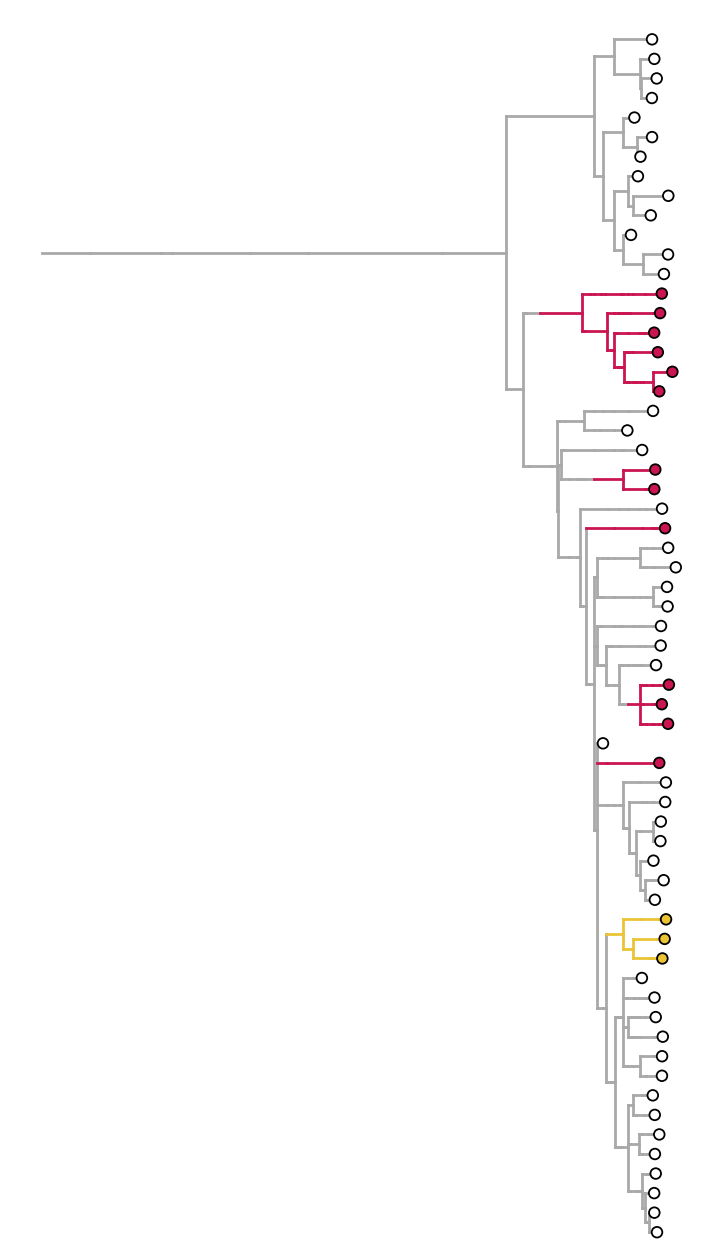

In [20]:
# Draw tree
fig = plt.figure(figsize=(9,16),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

point_size = lambda k: 40 if k.name in library_strains_ls else 0
point_colour = lambda k: '#eac435' if k.name in gold_descendants else '#ca1551' if k.name in red_descendants else 'white'  ## colour red if vaccine strain, blue if circulating, otherwise black
branch_colour = lambda k: '#eac435' if k.name in gold_descendants else '#ca1551' if k.name in red_descendants else 'darkgrey'  ## colour red if vaccine strain, blue if circulating, otherwise black

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

# Plot tree and points
circulating_library_tree.plotTree(
    ax,
    colour=branch_colour,
    linewidths=0.2,
    zorder=10
)  # Plot collapsed tree

# Plot points on leaves and internal nodes
circulating_library_tree.plotPoints(
    ax,
    target=lambda k: k.is_leaf(),
    size=point_size,
    colour=point_colour,  # Use the point_colour lambda to control color
    zorder=14
)


# X-axis tick params
ax.set_xticks([])
# Y-axis span
ax.set_ylim(0,circulating_library_tree.ySpan+1)
# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_yticks([])
ax.set_yticklabels([])


# # Start finagling the node labels
# target_func=lambda k: k.is_leaf() ## which branches will be annotated
# text_func=lambda k: k.name ## what text is plotted
# text_x_attr=lambda k: k.x + 0.2 ## where x coordinate for text is

# kwargs={'va':'center','ha':'left','size': 10,
#        } ## kwargs for text

# circulating_library_tree.addText(ax,
#                      x_attr=text_x_attr,
#                      target=target_func,
#                      text=text_func,
#                      **kwargs) ## text will use a different x attribute function to shift it to the right


plt.draw()

# Save plot
outfile = os.path.join('./results/circulating2023_library_noText.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

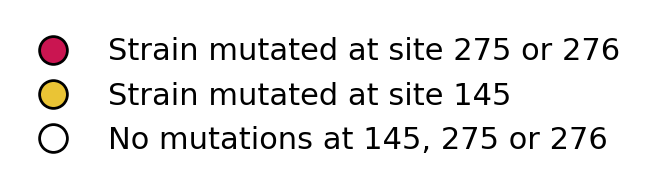

In [29]:
# Make key for egg-passaged versus cell-passaged versus 2023-circulating strains
plt.close()

fig = plt.figure(figsize=(4,2),facecolor='w') ## create figure

tree_key = {

    'Strain mutated at site 275 or 276':  '#ca1551', # palette red
    'Strain mutated at site 145': '#eac435', # palette yellow
    'No mutations at 145, 275 or 276': 'white', 

                   }


# draw a legend for the country to color mapping
# for circles: https://stackoverflow.com/a/44113141
patches = [plt.plot([], [], marker='o', markeredgecolor = 'black', markeredgewidth=2, ms=20, ls='', color=color, label=strain)[0]
           for strain, color in tree_key.items()]
plt.gca().set_axis_off()
legend = plt.legend(handles=patches,
                    loc='best',
                    frameon=False,
                    prop={'family': 'Sans'}
                   )

# draw just legend https://stackoverflow.com/a/47749903
tree_legend = './results/circulating_mutations_tree_legend.png'
fig = legend.figure
fig.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(tree_legend, bbox_inches='tight', dpi=600)

## Get ordered list of strains
This will be used in `seqneut-pipeline` and custom plotting notebooks to order strains phylogenetically. 

In [18]:
# Get list of tree elements for matching titer plots
ls = []

# Get names and y coordinates of tips
for k in library_tree.getExternal(): ## iterate over tips
    ls.append([k.name, k.y, k.traits['node_attrs']['accession']])

# Sort tips by y coordinate
sorted_ls = sorted(ls, key = lambda x: int(x[1]), reverse=True)

# Get a cleaned list of just the strain name (direct from the GISAID pull!) and the accession number
virus_order_list = []

for item in sorted_ls:
    strain = item[0]
    accession = item[2]

    if strain == 'A/HongKong/4801/2014':
        accession = 'EPI_ISL_165554'
        
    virus_order_list.append([strain, accession])

# Get dataframe
ordered_strains = pd.DataFrame(virus_order_list, columns = ['strain', 'accession'])
# Save to CSV
ordered_strains.to_csv('results/ordered_strains.csv', index=False)